In [1]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
from resources.plotting import Plotter
from tqdm.autonotebook import tqdm

from nltk.tokenize import WordPunctTokenizer, WhitespaceTokenizer

from rouge_score.rouge_scorer import RougeScorer
from resources.bart_score import BARTScorer
from resources.auc_score import AUCScorer
from resources.testing import PearsonCorrelationTester
from sklearn.metrics import f1_score, precision_score, recall_score

/tmp/ipykernel_2363014/3531749304.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
MODELS = {
    "Gemma - 2B":     "google/gemma-1.1-2b-it",
    "Gemma - 7B":     "google/gemma-1.1-7b-it",
    "Llama 3.1 - 8B": "meta-llama/Meta-Llama-3.1-8B-Instruct",
}

PLOTS_DIR  = "plots"

# Load results:

In [ ]:
RESULTS = {}

for key in MODELS:
    with open(f'results/food incidents - hazard/{MODELS[key]}.pkl', 'rb') as file:
        RESULTS[key] = pickle.load(file)

In [ ]:
pearson = PearsonCorrelationTester()
plotter = Plotter(RESULTS, i_sample=8, save_dir=PLOTS_DIR)
scorer  = AUCScorer(RESULTS)
plotter.print_chat("Llama 3.1 - 8B")

# Performance:

## F1

In [ ]:
for model in RESULTS:
    y_true = np.array([''.join(item['label']['tokens']) for item in RESULTS[model]])
    y_pred = np.array([''.join(item['prediction']['text'].split('\n\n')[0].strip('"*.')) for item in RESULTS[model]])
    
    print(model)
    print('  F1:              ', f1_score(y_true, y_pred, average='macro'))
    print('  precision:       ', precision_score(y_true, y_pred, average='macro'))
    print('  recall:          ', recall_score(y_true, y_pred, average='macro'))
    print()

# Faithfullness:

In [ ]:
plotter.plot_perturbation('Faithfullness - Food Hazard')
scorer.score_table()

Gemma - 2B

In [ ]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'].split('\n\n')[0].strip('"*.').lower() for r in RESULTS["Gemma - 2B"] for key in r['perturbation']],
    return_counts=True
)).T

Gemma - 7B

In [ ]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'].split('\n\n')[0].strip('"*.').lower() for r in RESULTS["Gemma - 7B"] for key in r['perturbation']],
    return_counts=True
)).T

Llama 3 - 8B

In [ ]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'] for r in RESULTS["Llama 3.1 - 8B"] for key in r['perturbation']],
    return_counts=True
)).T

# Self assessment:

In [ ]:
importance_human = {model:[] for model in RESULTS}
importance_self  = {model:[] for model in RESULTS}
importance_cf    = {model:[] for model in RESULTS}

for model in RESULTS:
    for r in RESULTS[model]:
        length = r['sample']['end'] - r['sample']['start']
        offset = r['sample']['start']
        
        importance_human[model].append(np.zeros(length, dtype=float))
        for i,j in r['spans']['human']: 
            importance_human[model][-1][i-offset:j-offset] = 1.
        importance_human[model][-1] /= max(importance_human[model][-1].sum(), 1e-9)
        
        importance_self[model].append(np.zeros(length, dtype=float))
        for i,j in r['spans']['extractive'][:len(r['spans']['human'])]:
            importance_self[model][-1][i-offset:j-offset] = 1.
        importance_self[model][-1] /= max(importance_self[model][-1].sum(), 1e-9)
        
        importance_cf[model].append(np.zeros(length, dtype=float))
        for i,j in r['spans']['counterfactual']:
            importance_cf[model][-1][i-offset:j-offset] = 1.
        importance_cf[model][-1] /= max(importance_cf[model][-1].sum(), 1e-9)

plotter.plot_importance([importance_human, importance_self, importance_cf], ['human', 'extractive', 'counterfactual'], f'Prompting-Based Explanations - Food Hazard')
pearson.add(importance_human, 'human')
pearson.add(importance_self,  'extractive')
pearson.add(importance_cf,    'counterfactual')

# AGrad:

In [ ]:
importance_agrad_raw = {model:[] for model in RESULTS}
importance_agrad     = {model:[] for model in RESULTS}

for model in RESULTS:
    for r in RESULTS[model]:
        # get sample boundaries:
        x_start = r['sample']['start']
        x_end   = r['sample']['end']
    
        # get importance:
        importance = np.abs(r['AGrad'][:, :, x_start:x_end])
    
        # per token in label:
        importance_agrad_raw[model].append({
            str(i): importance[i].mean(axis=0)
#            r['label']['tokens'][i]: importance[i,:,i].mean(axis=0)
            for i in range(importance.shape[0])
        })
    
        # combined:
        importance_agrad[model].append(importance.mean(axis=(0,1,)))

plotter.plot_importance([importance_agrad_raw, importance_agrad], ['', '$\\bf{Combined}$'], f'AGrad - Food Hazard')
pearson.add(importance_agrad, 'AGrad')

# GradIn

In [ ]:
importance_gradin_raw = {model:[] for model in RESULTS}
importance_gradin     = {model:[] for model in RESULTS}

for model in RESULTS:
    for r in RESULTS[model]:
        # get sample boundaries:
        start = r['sample']['start']
        end   = r['sample']['end']
    
        # get importance:
        importance = np.abs(r['GradIn'][:, start:end, :])
    
        importance_gradin_raw[model].append({
            #r['label']['tokens'][i]: importance[i,:,:].mean(axis=-1)
            str(i): importance[i,:,:].mean(axis=-1)
            for i in range(importance.shape[0])
        })
    
        importance_gradin[model].append(importance.cumsum(axis=0).mean(axis=(0,-1)))

plotter.plot_importance([importance_gradin_raw, importance_gradin], ['', '$\\bf{Combined}$'], f'GradIn - Food Hazard')
pearson.add(importance_gradin, 'GradIn')

# Grad$^{-1}$

In [ ]:
importance_igrad_raw = {model:[] for model in RESULTS}
importance_igrad     = {model:[] for model in RESULTS}

for model in RESULTS:
    for r in RESULTS[model]:
        # get sample boundaries:
        start = r['sample']['start']
        end   = r['sample']['end']
    
        # get importance:
        importance = np.abs(r['IGrad'][:,start:end,:])
    
        importance_igrad_raw[model].append({
            #r['label']['tokens'][i]: importance[i,:,:].mean(axis=-1)
            str(i): importance[i,:,:].mean(axis=-1)
            for i in range(importance.shape[0])
        })
    
        importance_igrad[model].append(importance.cumsum(axis=0).mean(axis=(0,-1)))

plotter.plot_importance([importance_igrad_raw, importance_igrad], ['', '$\\bf{Combined}$'], f'IGrad - Food Hazard')
pearson.add(importance_igrad, 'IGrad')

In [ ]:
scale = lambda d: {key: [(x - np.min(x)) / (np.max(x) - np.min(x)) for x in d[key]] for key in d}
plotter.plot_importance(
    [
        scale(importance_self),
        scale(importance_cf),
        scale(importance_human),
        scale(importance_agrad),
        scale(importance_gradin),
        scale(importance_igrad)
    ],
    ['extractive (self)', 'counterfactual (self)', 'human', 'AGrad', 'GradIn', 'IGrad'],
    f'Explanations Comparison - Food Hazard'
)

# Correlations:

In [ ]:
pearson.boxplot('human', path=f'{PLOTS_DIR}/PearsonViolin - Food Hazard - Human.pdf')

In [ ]:
pearson.boxplot('extractive', path=f'{PLOTS_DIR}/PearsonViolin - Food Hazard - Self.pdf')

In [ ]:
pearson.boxplot('counterfactual', path=f'{PLOTS_DIR}/PearsonViolin - Food Hazard - Counterfactual.pdf')

In [ ]:
pearson.matrixplot(title='Pearson Matrix - Food Hazard', dir=PLOTS_DIR)

# Gradient Saturation:

Gemma - 2B
  mean: 0.0
  std:  0.0
  min:  0.0
  max:  0.0

Gemma - 7B
  mean: 0.0
  std:  0.0
  min:  0.0
  max:  0.0

Llama 3.1 - 8B
  mean: 0.0
  std:  0.0
  min:  0.0
  max:  0.0



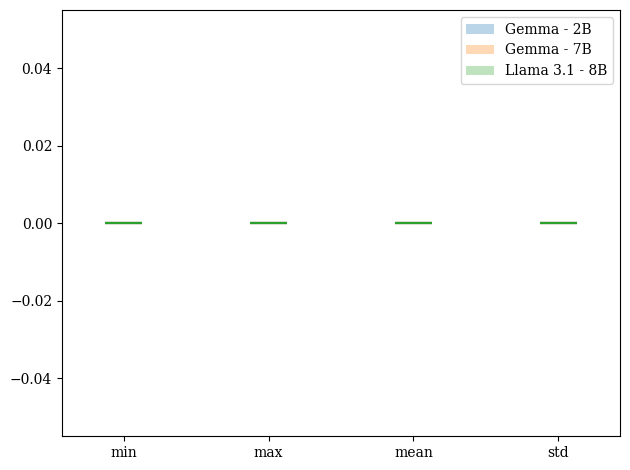

In [20]:
hs, ls = [], [] 
for model in RESULTS:
    grad_min = []
    grad_avg = []
    grad_std = []
    grad_max = []
    
    for r in RESULTS[model]:
        # get sample boundaries:
        start = r['sample']['start']
        end   = r['sample']['end']

        # get important window:
        grad = r['Grad'][:, start:end, :]
        
        grad_min.append(grad.min())
        grad_avg.append(grad.mean())
        grad_std.append(grad.std())
        grad_max.append(grad.max())
   
    hs.append(plt.violinplot([grad_min, grad_max, grad_avg, grad_std])['bodies'][0])
    ls.append(model)

    print(model)
    print('  mean:', np.mean(grad_avg))
    print('  std: ', np.mean(grad_std))
    print('  min: ', np.mean(grad_min))
    print('  max: ', np.mean(grad_max))
    print()

plt.xticks(ticks=[1, 2, 3, 4], labels=['min', 'max', 'mean', 'std'])
plt.legend(handles=hs, labels=ls)
plt.tight_layout()
plt.show()

# Counterfactual:

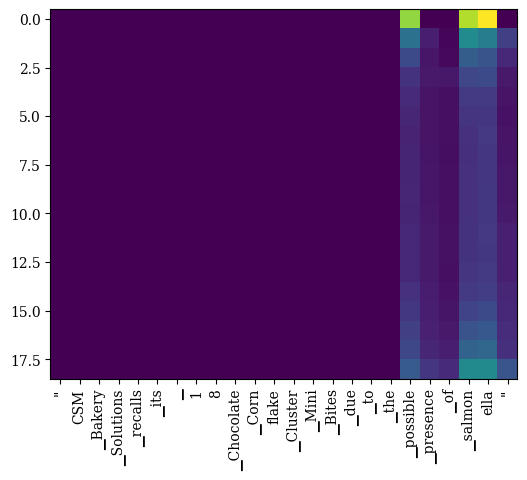

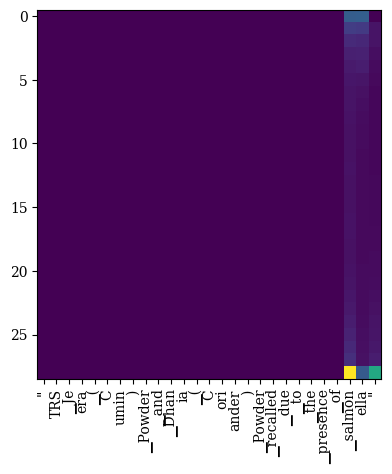

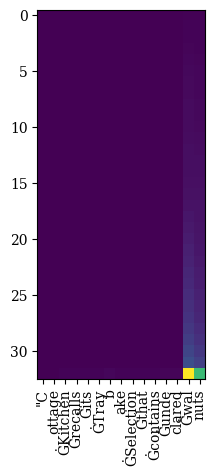

In [21]:
from sklearn.metrics import pairwise_distances

for model in RESULTS:
    r = np.random.choice(RESULTS[model])

    # get sample boundaries:
    start = r['sample']['start']
    end   = r['sample']['end']

    hs_cf = r['counterfactual']['hidden_states'][0,:,0,start:end]
    hs_r  = r['hidden_states'][0,:,0,start:end]

    err = []
    for layer in range(hs_cf.shape[0]):
        dist = pairwise_distances(hs_r[layer], hs_cf[layer], metric='euclidean')

        err.append(dist.min(axis=1))

    plt.imshow(err)
    plt.xticks(
        ticks    = range(end-start),
        labels   = r['tokens'][start:end],
        rotation = 90
    )
    plt.show()

/home/h21/kora8563/venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Gemma - 2B
  Success rate: 0.975
  Similarity: 0.9299471278812456
  ROUGE-1: 0.608234659975829
  BLEU-1: 0.5950593674180855
  ROUGE-L: 0.5957444278442803
  BART: -3.23112203280131

Gemma - 7B
  Success rate: 0.865
  Similarity: 0.9449893630226968
  ROUGE-1: 0.8068276860886285
  BLEU-1: 0.7062570208691037
  ROUGE-L: 0.7454048982015389
  BART: -2.1375512711574576

Llama 3.1 - 8B
  Success rate: 0.81
  Similarity: 0.9296623751296915
  ROUGE-1: 0.9016971943144454
  BLEU-1: 0.6745575903853792
  ROUGE-L: 0.7198273069893808
  BART: -3.0357244963999146



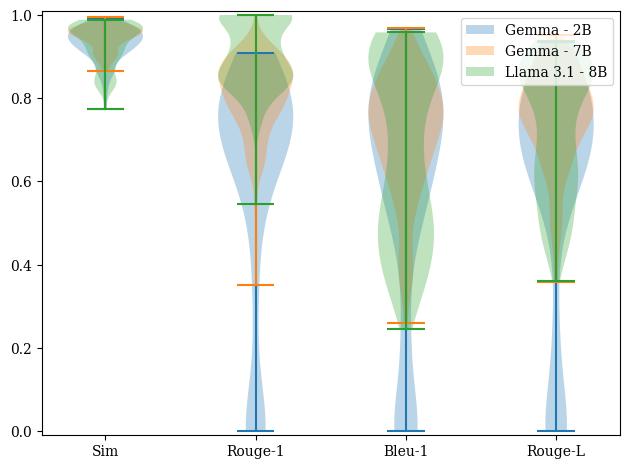

In [22]:
rouge_scorer = RougeScorer(['rouge1', 'rougeL'], tokenizer=WordPunctTokenizer())
bart_scorer = BARTScorer(device='cuda:0', checkpoint='facebook/bart-large-cnn')

hs, ls = [], [] 
for model in RESULTS:
    counterfactuals = []

    for r in RESULTS[model]:
        cf = r['counterfactual']
        success = cf['prediction'] != r['prediction']['text']
    
        rouge = rouge_scorer.score(r['sample']['text'].lower(), cf['text'].lower())
        bart = bart_scorer.score([r['sample']['text']], [cf['text'].lower()], batch_size=4)
        
        counterfactuals.append((
            int(success),
            cf['similarity'],
            rouge['rouge1'].recall,    # rouge
            rouge['rouge1'].precision, # bleu
            rouge['rougeL'].fmeasure,
            bart[0]
        ))
    
    counterfactuals = np.array(counterfactuals, dtype=float)

    hs.append(plt.violinplot(counterfactuals[counterfactuals[:,0] == 1., 1:-1])['bodies'][0])
    ls.append(model)

    print(model)
    print('  Success rate:', counterfactuals[:,0].mean())
    print('  Similarity:', counterfactuals[counterfactuals[:,0] == 1., 1].mean())
    print('  ROUGE-1:', counterfactuals[counterfactuals[:,0] == 1., 2].mean())
    print('  BLEU-1:', counterfactuals[counterfactuals[:,0] == 1., 3].mean())
    print('  ROUGE-L:', counterfactuals[counterfactuals[:,0] == 1., 4].mean())
    print('  BART:', counterfactuals[counterfactuals[:,0] == 1., 5].mean())
    print()

plt.ylim(bottom=-.01, top=1.01)
plt.xticks(ticks=[1, 2, 3, 4], labels=['Sim', 'Rouge-1', 'Bleu-1', 'Rouge-L'])
plt.legend(handles=hs, labels=ls)
plt.tight_layout()
plt.show()